## BigMart Sales Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Rupakanth/Projects/master/BigMart%20Sales/Data/train_v9rqX0R.csv')

In [3]:
test = pd.read_csv('https://raw.githubusercontent.com/Rupakanth/Projects/master/BigMart%20Sales/Data/test_AbJTz2l.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
train1 = train.copy()
test1 = test.copy()

In [6]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
import pandas_profiling as pp

In [9]:
pp.ProfileReport(train)

Number of variables,12
Number of observations,8523
Total Missing (%),3.8%
Total size in memory,799.2 KiB
Average record size in memory,96.0 B
Numeric,5
Categorical,7
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [12]:
profile = pp.ProfileReport(train)
profile.to_file('your_report.html')

In [13]:
train.Outlet_Size.unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [14]:
train.Outlet_Establishment_Year.unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004], dtype=int64)

In [15]:
pd.crosstab(train.Outlet_Establishment_Year,train.Outlet_Size)

Outlet_Size,High,Medium,Small
Outlet_Establishment_Year,,,
1985,0,935,528
1987,932,0,0
1997,0,0,930
1999,0,930,0
2004,0,0,930
2009,0,928,0


In [16]:
pd.crosstab([train.Outlet_Establishment_Year,train.Outlet_Size],train.Outlet_Location_Type)

Outlet_Location_Type                   Tier 1  Tier 2  Tier 3
Outlet_Establishment_Year Outlet_Size                        
1985                      Medium            0       0     935
                          Small           528       0       0
1987                      High              0       0     932
1997                      Small           930       0       0
1999                      Medium          930       0       0
2004                      Small             0     930       0
2009                      Medium            0       0     928

from the above table if the mart is built in the year                             
1985 and the Outlet_Location_Type  is Tier 3 the outlet size is Medium             
1985 and the Outlet_Location_Type  is Tier 1 the outlet size is Small                        
1987 the outlet_size is high                  
1997 the outlet size is small                  
1999 the outlet size is medium                  
2004 the outlet size is small              
2009 the outlet size is medium               

Based on above information we can fill the missing values in the Outlet_Size

In [17]:
train[train.Outlet_Size.isna()].Outlet_Establishment_Year.unique()

array([1998, 2002, 2007], dtype=int64)

since the year are very differnt in the null values these cannot be used for filling missing values

In [18]:
pd.crosstab(train.Outlet_Location_Type,train.Outlet_Size)

Outlet_Size,High,Medium,Small
Outlet_Location_Type,,,
Tier 1,0,930,1458
Tier 2,0,0,930
Tier 3,932,1863,0


In [19]:
train[train.Outlet_Size.isna()].Outlet_Location_Type.unique()

array(['Tier 3', 'Tier 2'], dtype=object)

**If the Outlet_Location_type is Tier 2 we can fill Outlet_size with small**

In [20]:
pd.crosstab(train.Outlet_Identifier,train.Outlet_Size)

Outlet_Size,High,Medium,Small
Outlet_Identifier,,,
OUT013,932,0,0
OUT018,0,928,0
OUT019,0,0,528
OUT027,0,935,0
OUT035,0,0,930
OUT046,0,0,930
OUT049,0,930,0


In [21]:
train[train.Outlet_Size.isna()].Outlet_Identifier.unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

Null values Outlet_Size cannot be filled be filled with help of Outlet_Identifier

In [22]:
pd.crosstab(train.Outlet_Type,train.Outlet_Size)

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0,0,528
Supermarket Type1,932,930,1860
Supermarket Type2,0,928,0
Supermarket Type3,0,935,0


In [23]:
train[train.Outlet_Size.isna()].Outlet_Type.unique()

array(['Grocery Store', 'Supermarket Type1'], dtype=object)

In [24]:
train[train.Outlet_Size.isna()].Outlet_Location_Type.unique()

array(['Tier 3', 'Tier 2'], dtype=object)

In [25]:
pd.crosstab([train.Outlet_Type,train.Outlet_Size],train.Outlet_Location_Type)

Outlet_Location_Type           Tier 1  Tier 2  Tier 3
Outlet_Type       Outlet_Size                        
Grocery Store     Small           528       0       0
Supermarket Type1 High              0       0     932
                  Medium          930       0       0
                  Small           930     930       0
Supermarket Type2 Medium            0       0     928
Supermarket Type3 Medium            0       0     935

In [26]:
train[train.Outlet_Size.isna()][['Outlet_Type','Outlet_Location_Type','Outlet_Size']][train['Outlet_Type'] == 'Grocery Store'].Outlet_Location_Type.unique()

array(['Tier 3'], dtype=object)

In [27]:
train[train.Outlet_Size.isna()][['Outlet_Type','Outlet_Location_Type','Outlet_Size']][train['Outlet_Type'] == 'Supermarket Type1'].Outlet_Location_Type.unique()

array(['Tier 2'], dtype=object)

we see that for **'Outlet_Type'=> 'Grocery Store'** null values in in 'Outlet_Size' are in **'Outlet_Location_Type'=> 'Tier 3'** which can be filled with **'High'**

we see that for **'Outlet_Type'=> 'Supermarket Type1'** null values in in 'Outlet_Size' are in **'Outlet_Location_Type'=> 'Tier 2'** which can be filled with **'Small'**

with these filling all the null values in Outlet_Size can be filled.

Now we have to deal with null values in item_weight which are 1463

In [28]:
train.corr()[:1]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.0,-0.014048,0.027141,-0.011588,0.014123


Item_weight is not having much correlation with any of the other numerical columns, Lets us interplotae to fill null values in Item_weights

In [29]:
def f(r):
    if (r.Outlet_Type == 'Grocery Store') & (r.Outlet_Location_Type == 'Tier 3') :
        return 'High'
    elif (r.Outlet_Type == 'Supermarket Type1') & (r.Outlet_Location_Type == 'Tier 2'):
        return 'Small'
    else:
        return r.Outlet_Size

train['Outlet_Size1'] = train.apply(f,axis =1)
test['Outlet_Size1'] = test.apply(f,axis =1)

In [30]:
train['Item_Weight'].interpolate(inplace = True)
test['Item_Weight'].interpolate(inplace = True)

In [31]:
train.drop(columns = 'Outlet_Size',inplace = True)
test.drop(columns = 'Outlet_Size',inplace = True)

In [32]:
train.rename(columns = {'Outlet_Size1' : 'Outlet_Size'},inplace = True)
test.rename(columns = {'Outlet_Size1' : 'Outlet_Size'},inplace = True)

In [33]:
Fat_Content = {'Low Fat' : 1,
              'Regular':0,
              'low fat':1,
              'LF':1,
              'reg':0}

train['Item_Fat_Content'] = train['Item_Fat_Content'].map(lambda x : Fat_Content[x] )
test['Item_Fat_Content'] = test['Item_Fat_Content'].map(lambda x : Fat_Content[x] )

In [34]:
train.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Outlet_Size                  0
dtype: int64

In [35]:
test.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Outlet_Size                  0
dtype: int64

both the train and test data sets have no missing values

In [36]:
train.select_dtypes(include = 'object')

,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Outlet_Size
0,FDA15,Dairy,OUT049,Tier 1,Supermarket Type1,Medium
1,DRC01,Soft Drinks,OUT018,Tier 3,Supermarket Type2,Medium
2,FDN15,Meat,OUT049,Tier 1,Supermarket Type1,Medium
3,FDX07,Fruits and Vegetables,OUT010,Tier 3,Grocery Store,High
4,NCD19,Household,OUT013,Tier 3,Supermarket Type1,High
...,...,...,...,...,...,...
8518,FDF22,Snack Foods,OUT013,Tier 3,Supermarket Type1,High
8519,FDS36,Baking Goods,OUT045,Tier 2,Supermarket Type1,Small
8520,NCJ29,Health and Hygiene,OUT035,Tier 2,Supermarket Type1,Small
8521,FDN46,Snack Foods,OUT018,Tier 3,Supermarket Type2,Medium


Item_identifier is the Unique ProductID of the product, and Outlet_Identifier id storeId both have no significance in Item_Outlet_Sales  hence can be dropped

In [37]:
train.drop(columns = ['Item_Identifier','Outlet_Identifier'],inplace = True)
test.drop(columns = ['Item_Identifier','Outlet_Identifier'],inplace = True)

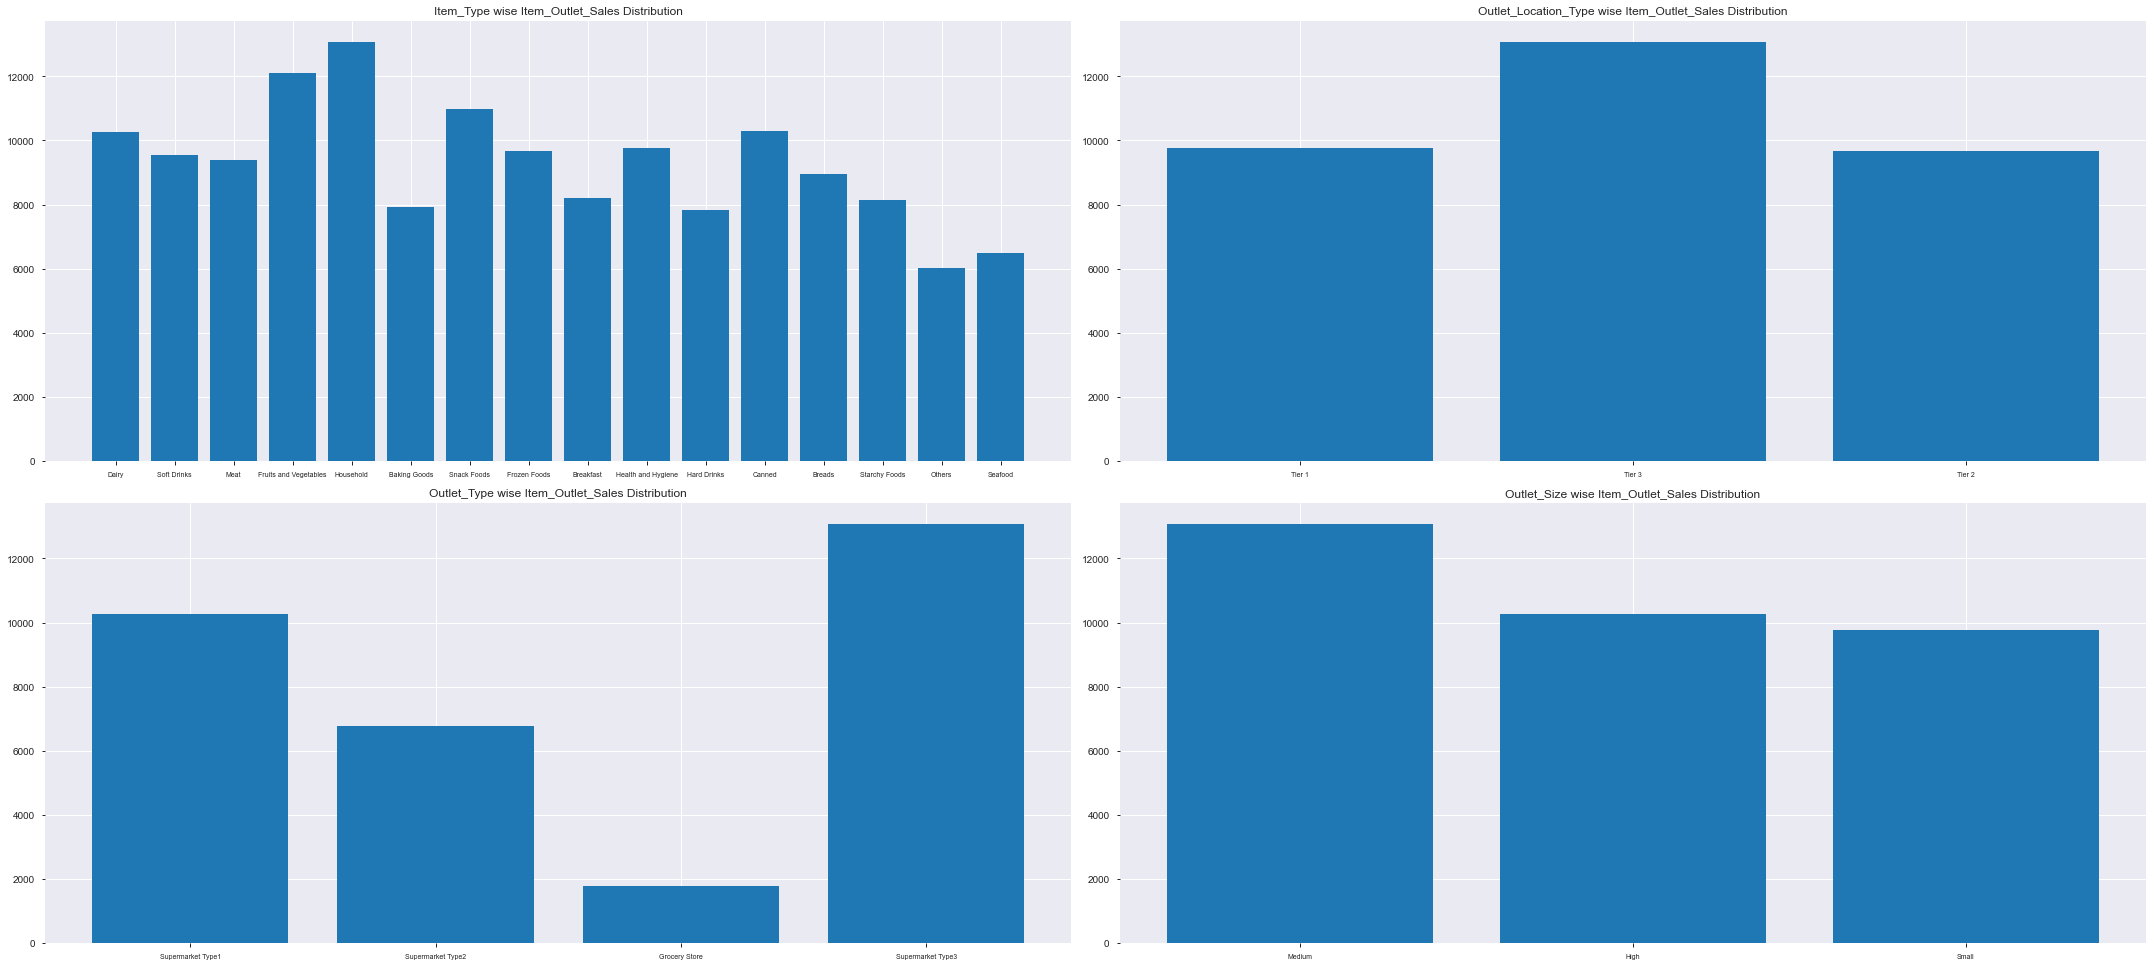

In [59]:
cat_columns = train.select_dtypes(include = 'object').columns
fig = plt.figure(figsize= (30,20))
for i,col in enumerate(cat_columns):
    ax = fig.add_subplot(3,2,i+1)
    plt.bar(train[col],train['Item_Outlet_Sales'])
    ax.xaxis.set_tick_params(labelsize=7)

    ax.set_title(col + ' wise Item_Outlet_Sales Distribution')
fig.tight_layout()
plt.show()
    

we see that all the categorical columns have some contribution to the Item_Outlet_Sales

In [39]:
train[cat_columns]

,Item_Type,Outlet_Location_Type,Outlet_Type,Outlet_Size
0,Dairy,Tier 1,Supermarket Type1,Medium
1,Soft Drinks,Tier 3,Supermarket Type2,Medium
2,Meat,Tier 1,Supermarket Type1,Medium
3,Fruits and Vegetables,Tier 3,Grocery Store,High
4,Household,Tier 3,Supermarket Type1,High
...,...,...,...,...
8518,Snack Foods,Tier 3,Supermarket Type1,High
8519,Baking Goods,Tier 2,Supermarket Type1,Small
8520,Health and Hygiene,Tier 2,Supermarket Type1,Small
8521,Snack Foods,Tier 3,Supermarket Type2,Medium


In [40]:
int_columns = list(train.select_dtypes(exclude = 'object').columns)
int_columns.remove('Outlet_Establishment_Year')
int_columns.remove('Item_Outlet_Sales')
int_columns

['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP']

In [41]:
int_columns

['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP']

In [42]:
cat_pipeline = make_pipeline(OrdinalEncoder())
int_pipeline = make_pipeline(StandardScaler())

In [43]:
preprocessor = make_column_transformer(
                (cat_pipeline,cat_columns),
                (int_pipeline,int_columns),
                remainder = 'passthrough')

In [45]:
features = train.drop(columns = 'Item_Outlet_Sales')
target = train['Item_Outlet_Sales']

In [46]:
trainX,testX,trainY,testY = train_test_split(features,target)

# RandomForest

In [60]:
pipeline_rf = make_pipeline(preprocessor,RandomForestRegressor())
pipeline_rf.fit(trainX,trainY)
y_pred = pipeline_rf.predict(testX)
print('rme',sqrt(mean_squared_error(testY,y_pred)))
print('r2_score',r2_score(testY,y_pred))

rme 1184.1410395356463
r2_score 0.5186676104207819


## Fine tuning RF

In [51]:
pipeline_rf

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories='auto',
                                                                                  dtype=<class 'numpy.float64'>))],
                                                           verbose=False),
                                                  Index(['Item_Type', 'Outlet_Location_Type', 'Outl...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                   

In [52]:
params = {'randomforestregressor__n_estimators':[10,11,13,15],'randomforestregressor__max_depth':[10,11,12,14]}

In [53]:
rs_rf =  RandomizedSearchCV(pipeline_rf,params,n_jobs= 3)

In [54]:

params = {'randomforestregressor__n_estimators':[16,17,19,20,21],'randomforestregressor__max_depth':[5,6,7]}

rs_rf =  RandomizedSearchCV(pipeline_rf,params,n_jobs= 3,random_state= 300)
rs_rf.fit(trainX,trainY)
y_pred = rs_rf.predict(testX)
print('rme',sqrt(mean_squared_error(testY,y_pred)))
print('r2_score',r2_score(testY,y_pred))

rme 1084.7559232784279
r2_score 0.5960735603752609


In [55]:
rs_rf.best_params_

{'randomforestregressor__n_estimators': 19,
 'randomforestregressor__max_depth': 5}

In [56]:
y_pred = rs_rf.predict(test)
rs_rf_predictions = test1[['Item_Identifier','Outlet_Identifier']].join(pd.DataFrame(y_pred))
rs_rf_predictions.rename(columns = {0:'Item_Outlet_Sales'},inplace = True)
rs_rf_predictions.to_csv('rf_final.csv',index = False)

## full training

In [57]:
rs_rf.fit(features,target)

y_pred = rs_rf.predict(test)
rs_rf_predictions = test1[['Item_Identifier','Outlet_Identifier']].join(pd.DataFrame(y_pred))
rs_rf_predictions.rename(columns = {0:'Item_Outlet_Sales'},inplace = True)
rs_rf_predictions.to_csv('rf_fine_tuned_fullytrained.csv',index = False)

In [55]:
from joblib import dump

In [57]:
dump(rs_rf,filename='BigMart_modl.joblib')

['BigMart_modl.joblib']